In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
age_gender_info = pd.read_csv('./data/age_gender_info.csv')
submission = pd.read_csv('./data/sample_submission.csv')

## 컬럼명 변경

In [3]:
train.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
                 '임대보증금', '임대료', '지하철', '버스', '단지내주차면수', '등록차량수']

test.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
                '임대보증금', '임대료', '지하철', '버스', '단지내주차면수']

## 지역명 숫자로 매핑

In [4]:
local_map = {}
for i, loc in enumerate(train['지역'].unique()):
    local_map[loc] = i

In [5]:
train['지역'] = train['지역'].map(local_map)
test['지역'] = test['지역'].map(local_map)

In [6]:
train['전용면적'] = train['전용면적']//5*5
test['전용면적'] = test['전용면적']//5*5

## 전용면적을 5의 배수로 변경

In [7]:
idx = train[train['전용면적'] > 100].index
train.loc[idx, '전용면적'] = 100
idx = test[test['전용면적'] > 100].index
test.loc[idx, '전용면적'] = 100

idx = train[train['전용면적'] < 15].index
train.loc[idx, '전용면적'] = 15
idx = test[test['전용면적'] < 15].index
test.loc[idx, '전용면적'] = 15

## 단지별 데이터 1차원으로 취합

In [8]:
columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique():
    area_columns.append(f'면적_{area}')

In [9]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [10]:
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()

423it [00:06, 62.78it/s]
150it [00:02, 65.68it/s]


In [11]:
new_train

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,면적_35.0,면적_50.0,면적_55.0,...,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0,등록차량수
0,C2483,900.0,38.0,0.0,1425.0,0.0,3.0,149.0,665.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,17.0,1.0,624.0,0.0,3.0,80.0,132.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,13.0,2.0,1285.0,1.0,1.0,0.0,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0
3,C1945,755.0,6.0,3.0,734.0,1.0,3.0,240.0,303.0,212.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730.0
4,C1470,696.0,14.0,4.0,645.0,0.0,2.0,254.0,246.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,553.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,C2586,90.0,7.0,9.0,66.0,0.0,3.0,36.0,0.0,0.0,...,42.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
419,C2035,492.0,24.0,5.0,521.0,0.0,1.0,156.0,0.0,0.0,...,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0
420,C2020,40.0,7.0,8.0,25.0,1.0,2.0,15.0,0.0,0.0,...,5.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
421,C2437,90.0,12.0,11.0,30.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,16.0


## 결측치 처리

In [12]:
new_train = new_train.fillna(-1)
new_test = new_test.fillna(-1)

## 학습

In [13]:
x_train = new_train.iloc[:, 1:-1]
y_train = new_train.iloc[:,-1]
x_test = new_test.iloc[:,1:]

In [14]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [15]:
model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

## 추론 및 제출

In [16]:
pred = model.predict(x_test)

In [17]:
submission['num'] = pred

In [18]:
submission.to_csv('baseline.csv', index=False)

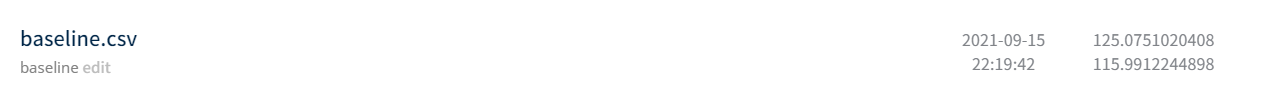

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [22]:
pred = model.predict(x_train)

In [23]:
mean_absolute_error(y_train, pred)

47.79430260047281